In [1]:
import fastai
from fastai.vision.all import *
from fastdownload import FastDownload
from models.CycleGan import CombndGens, CombndDiscs, CycleGANLearner
from torchsummary import summary
from util.util import GANIntToFloatTensor
from IPython.core.debugger import set_trace
from typing import List

In [2]:
path = Path('data')
Path.BASE_PATH = path

In [3]:
if not (path/'archive').exists():
    loader = FastDownload(base=path.name, data='extracted', module=fastai.data)
    loader.get("https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip")

In [4]:
train_path = path/'extracted/apple2orange'

In [5]:
# Idea from Siamese tutorial: https://docs.fast.ai/tutorial.siamese.html
class ImageTuple(fastuple):
    
    @classmethod
    def create(cls, paths):
        return cls(tuple(PILImage.create(p) for p in paths))
    
    @classmethod
    def from_tensors(cls, imgs: List[TensorImage]):
        return cls(tuple(imgs))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

    
def ImageTupleBlock():
    return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=GANIntToFloatTensor)

In [6]:
def get_image_tuples(path: Path, domain_a: str = 'trainA', domain_b: str = 'trainB'):
    imgs_a = get_image_files(path/domain_a)
    imgs_b = get_image_files(path/domain_b)
    
    # Note that this is a list of lists and not a list of tuples. When using a
    # list of tuples, it appears fastai just passes the first element to get_x and get_y
    # instead of the entire tuple.
    return [list(pair + ('apple_orange',)) for pair in zip(imgs_a, imgs_b)]

def get_x(tup):
    return tup[:2]

def get_y(tup):
    return tup[2]

In [7]:
datablock = DataBlock(blocks=(ImageTupleBlock, CategoryBlock),
                      get_items=get_image_tuples,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=RandomSplitter(seed=42),
                      item_tfms=Resize(128))

In [8]:
dataloaders = datablock.dataloaders(train_path)

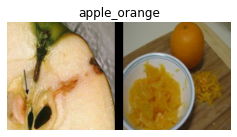

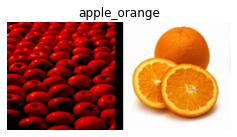

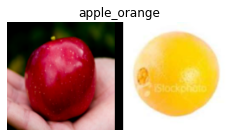

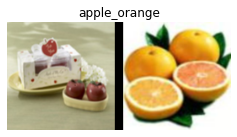

In [9]:
dataloaders.show_batch(max_n=4)

In [10]:
generator = CombndGens(input_shape=[3, 128, 128],
                       filters=[32, 64, 128, 256],
                       ds_kernel_size=5,
                       us_kernel_size=5,
                       ds_stride=2,
                       us_stride=1)

In [11]:
discriminator = CombndDiscs(input_shape=[3, 128, 128],
                            filters=[32, 64, 128, 256],
                            kernel_size=5)

In [12]:
learner = CycleGANLearner(dataloaders=dataloaders,
                         generator=generator,
                         discriminator=discriminator,
                         opt_func=Adam)

learner.recorder.train_metrics = True
learner.recorder.valid_metrics = False

In [13]:
learner.fit(50, 2e-4)

epoch,train_loss,gen_loss,disc_loss,time
0,6.944889,12.251760,0.646019,00:14
1,5.980383,10.271469,0.323066,00:08
2,5.489284,9.466929,0.240675,00:08
3,5.122447,8.735154,0.215897,00:08
4,4.874629,8.515328,0.201840,00:08
5,4.681942,8.278321,0.194657,00:08
6,4.504439,7.908892,0.192592,00:08
7,4.376206,7.865019,0.193094,00:08
8,4.228373,7.431612,0.174651,00:08
9,4.116831,7.406286,0.177195,00:08


In [14]:
dl = learner.dls[0].new(shuffle=True)
batch = dl.one_batch()
_, _, preds = learner.get_preds(dl=[batch], with_decoded=True)
tfm = GANIntToFloatTensor()
imgs = ImageTuple.from_tensors([tfm.decodes(b[0]) for b in preds[:2]])

In [15]:
imgs[0].shape

torch.Size([3, 128, 128])

In [16]:
imgs[1].shape

torch.Size([3, 128, 128])

<AxesSubplot:>

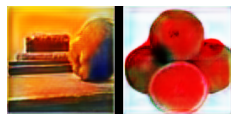

In [17]:
imgs.show()

In [37]:
imgs[0]

TensorImage([[[162, 167, 154,  ..., 145, 145, 149],
         [158, 140, 105,  ..., 100, 107, 110],
         [157, 142, 104,  ..., 109,  86,  96],
         ...,
         [123, 104,  79,  ..., 137, 119, 126],
         [129, 122, 127,  ..., 154, 135, 144],
         [137, 136, 142,  ..., 150, 136, 145]],

        [[119, 132, 149,  ..., 160, 160, 140],
         [121, 124, 134,  ..., 131, 125, 120],
         [110, 115, 145,  ..., 133, 140, 126],
         ...,
         [ 85,  74, 109,  ..., 113, 119, 132],
         [ 97,  88,  96,  ..., 104, 101, 121],
         [106,  87,  98,  ..., 111, 109, 124]],

        [[ 94,  82,  94,  ..., 124,  94, 100],
         [ 98,  86, 102,  ..., 116, 101, 101],
         [ 74,  78,  92,  ..., 103,  87,  98],
         ...,
         [ 75,  86,  78,  ...,  89, 100,  92],
         [ 88,  83,  76,  ...,  87,  97,  85],
         [ 97, 100,  95,  ...,  88,  94,  87]]])